In [35]:
# Import necessary libraries for building, training, and evaluating a neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# Step 1: Environment Setup and Parameter Initialization

#Choosing the right hardware
device_type = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation will run on: {device_type}")

# Initializing all the necessary training parameters for the project.
opt_step_size = 1e-3
samples_per_batch = 64
epochs_total = 20
compressed_vector_size = 32

#This block configures the processing backend (CPU or GPU)
#and sets essential settings such as learning rate, batch size, training epochs, and encoder latent vector size.


Computation will run on: cpu


In [37]:
# Step 2: Loading and Preparing the MNIST Dataset

# Defining transformations to apply to the images:

preprocess_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Single-channel normalization for grayscale images
])
# We're converting photos from PIL format to PyTorch tensors
#and scaling pixel intensity values from [0,1] to [-1,1] for greater stability.

In [38]:
# Import and Prepare the MNIST Training Data

# Initializing the training data of the MNIST dataset
# Downloading the dataset to the provided path.
mnist_train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=preprocess_pipeline,
    download=True
)

# Configuring the data loader to do batching and shuffling during training
train_loader = DataLoader(
    dataset=mnist_train_data,
    batch_size=samples_per_batch,
    shuffle=True
)


In [39]:
#  Loading and Preparing the MNIST Test Data

# Accessing test data from the MNIST dataset
# If the data cannot be located in the provided directory, it will be downloaded automatically.
mnist_test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=preprocess_pipeline,
    download=True
)
# Configuring the DataLoader for the test set
# Shuffling is not required here because order doesn't effect evaluation.
test_loader = DataLoader(
    dataset=mnist_test_data,
    batch_size=samples_per_batch,
    shuffle=False
)

# displaying the basic dataset information
print(f"Number of training samples: {len(mnist_train_data)}")
print(f"Number of test samples: {len(mnist_test_data)}")
print(f"Dimensions of a single image: {mnist_train_data[0][0].shape}")


Number of training samples: 60000
Number of test samples: 10000
Dimensions of a single image: torch.Size([1, 28, 28])


In [40]:
#This step comprises obtaining and loading the MNIST dataset for training and testing.
#The approach involves transforming photos into PyTorch tensors, standardizing pixel values, and organizing them for batch processing.

In [41]:
#  Step 3: Defining the Convolutional Autoencoder Architecture


class ConvAutoencoder(nn.Module):
    """
    A deep convolutional autoencoder designed specifically for MNIST digit pictures.
     The encoder compresses the input image into a latent vector,
     and the decoder reconstructs the image from the compressed representation.
    """
    def __init__(self, code_size):
        super(ConvAutoencoder, self).__init__()
        self.code_size = code_size

        # The encoder block compresses 1x28x28 input into a compact latent code.
        self.compress_block = nn.Sequential(
            # From 1 input channel to 16, the spatial size decreases to 14x14.
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # From 16 to 32 channels, the spatial size decreases to 7x7.
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # Flatten the output to a vector of length 32*7*7
            nn.Linear(32 * 7 * 7, self.code_size)
        )

        # Decoder block: extending the latent code back to 1x28x28 picture.
        self.reconstruct_block = nn.Sequential(
            nn.Linear(self.code_size, 32 * 7 * 7),  # Expanding the image back to 3D shape
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(32, 7, 7)),  # Reshaping to 3D tensor
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        """
        Full forward pass encodes and reconstructs the input.
        """
        latent_code = self.compress_block(x)
        output_image = self.reconstruct_block(latent_code)
        return output_image

    def encode_only(self, x):
        """
       Extract an encoded latent representation from an input image.
        """
        return self.compress_block(x)

    def decode_only(self, z):
        """
        Reconstruct an image from a latent code.
        """
        return self.reconstruct_block(z)

# Create an instance of the model and move it to the appropriate compute device.
model_instance = ConvAutoencoder(code_size=compressed_vector_size).to(device_type)
print("Autoencoder model structure:")
print(model_instance)


# This block creates the ConvAutoencoder class with convolutional and transposed convolutional layers.
#  The encoder compresses input images into a lower-dimensional code, which the decoder then uses to reassemble images.
#  There are two additional methods available for direct access to the encoder and decoder: 'encode_only' and 'decode_only'.


Autoencoder model structure:
ConvAutoencoder(
  (compress_block): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=1568, out_features=32, bias=True)
  )
  (reconstruct_block): Sequential(
    (0): Linear(in_features=32, out_features=1568, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(32, 7, 7))
    (3): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): Tanh()
  )
)


In [42]:
# Step 4: Configure Loss Function and Optimizer


# Initializing the loss metric
loss_metric = nn.MSELoss()

# Seting up the optimizer
optimizer_engine = optim.Adam(model_instance.parameters(), lr=opt_step_size)

print(f"Chosen Optimizer: Adam | Learning Rate: {opt_step_size}")
print(f"Loss Function Used: Mean Squared Error (MSELoss)")


# This step defines the MSE loss, which evaluates how well the output image matches the input.
# The Adam optimizer updates model weights based on training loss,
#it was selected because of its adaptive learning rate capabilities and convergence reliability


Chosen Optimizer: Adam | Learning Rate: 0.001
Loss Function Used: Mean Squared Error (MSELoss)


Epoch [1/20] | Batch [100/938] | Loss: 0.1788
Epoch [1/20] | Batch [200/938] | Loss: 0.0855
Epoch [1/20] | Batch [300/938] | Loss: 0.0640
Epoch [1/20] | Batch [400/938] | Loss: 0.0484
Epoch [1/20] | Batch [500/938] | Loss: 0.0390
Epoch [1/20] | Batch [600/938] | Loss: 0.0420
Epoch [1/20] | Batch [700/938] | Loss: 0.0399
Epoch [1/20] | Batch [800/938] | Loss: 0.0356
Epoch [1/20] | Batch [900/938] | Loss: 0.0404
Epoch [1/20] completed | Average Loss: 0.0839
Epoch [2/20] | Batch [100/938] | Loss: 0.0390
Epoch [2/20] | Batch [200/938] | Loss: 0.0331
Epoch [2/20] | Batch [300/938] | Loss: 0.0328
Epoch [2/20] | Batch [400/938] | Loss: 0.0349
Epoch [2/20] | Batch [500/938] | Loss: 0.0284
Epoch [2/20] | Batch [600/938] | Loss: 0.0330
Epoch [2/20] | Batch [700/938] | Loss: 0.0308
Epoch [2/20] | Batch [800/938] | Loss: 0.0294
Epoch [2/20] | Batch [900/938] | Loss: 0.0237
Epoch [2/20] completed | Average Loss: 0.0317
Epoch [3/20] | Batch [100/938] | Loss: 0.0329
Epoch [3/20] | Batch [200/938] | L

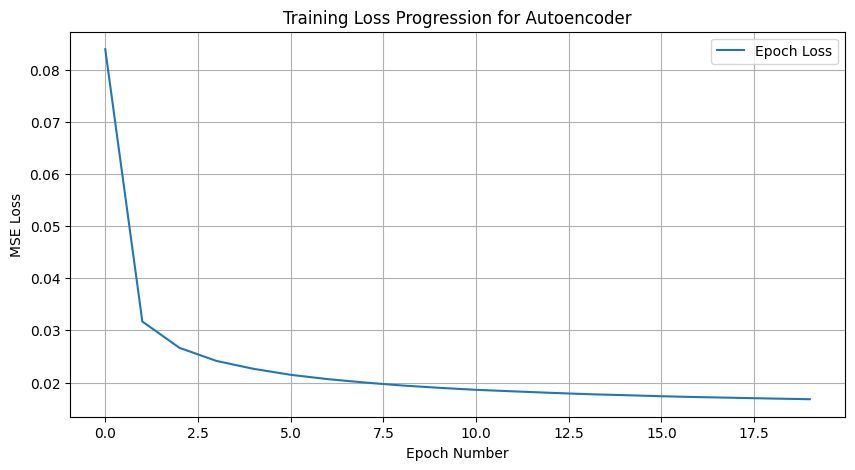

In [43]:
# Step 5: Training the Autoencoder Model


# Creating a list to track the average loss for each period.
epoch_loss_log = []

# Start the training for the chosen number of passes over the dataset.
for epoch_num in range(epochs_total):
    model_instance.train()
    cumulative_epoch_loss = 0.0

    # Iterating over the mini-batches of training data
    for batch_idx, (image_batch, _) in enumerate(train_loader):
        # Moving data to the appropriate processing device (GPU/CPU).
        image_batch = image_batch.to(device_type)

        # Forward pass: produce reconstructed pictures from input.
        predicted_images = model_instance(image_batch)

        # Calculate the loss in reconstruction between the original and forecasted pictures.
        batch_loss = loss_metric(predicted_images, image_batch)

        # Backpropagation and parameter update
        optimizer_engine.zero_grad()  # Clear previous gradient values
        batch_loss.backward()         # Compute gradients
        optimizer_engine.step()       # Apply gradients to model parameters

        # Calculate the overall loss for the current epoch.
        cumulative_epoch_loss += batch_loss.item()

        #Periodic recording of training status.
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch_num + 1}/{epochs_total}] | "
                  f"Batch [{batch_idx + 1}/{len(train_loader)}] | "
                  f"Loss: {batch_loss.item():.4f}")

    # compute and record the mean loss for this epoch.
    average_loss = cumulative_epoch_loss / len(train_loader)
    epoch_loss_log.append(average_loss)
    print(f"Epoch [{epoch_num + 1}/{epochs_total}] completed | "
          f"Average Loss: {average_loss:.4f}")

print("Model training completed successfully.")

# Create and save a graph displaying training loss over all epochs.
plt.figure(figsize=(10, 5))
plt.plot(epoch_loss_log, label='Epoch Loss')
plt.title('Training Loss Progression for Autoencoder')
plt.xlabel('Epoch Number')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
#plt.savefig("training_loss.png")  # Save loss curve image
#print("Loss plot saved as 'training_loss.png'")
plt.show()


#The loop executes the basic learning process, including forward and backward network runs,
# weight optimization based on MSE loss, and performance logging.  Following training, it creates
# a loss plot to show the network's reconstruction performance over time.


The Mean Reconstruction Error on Test Set: 0.0167


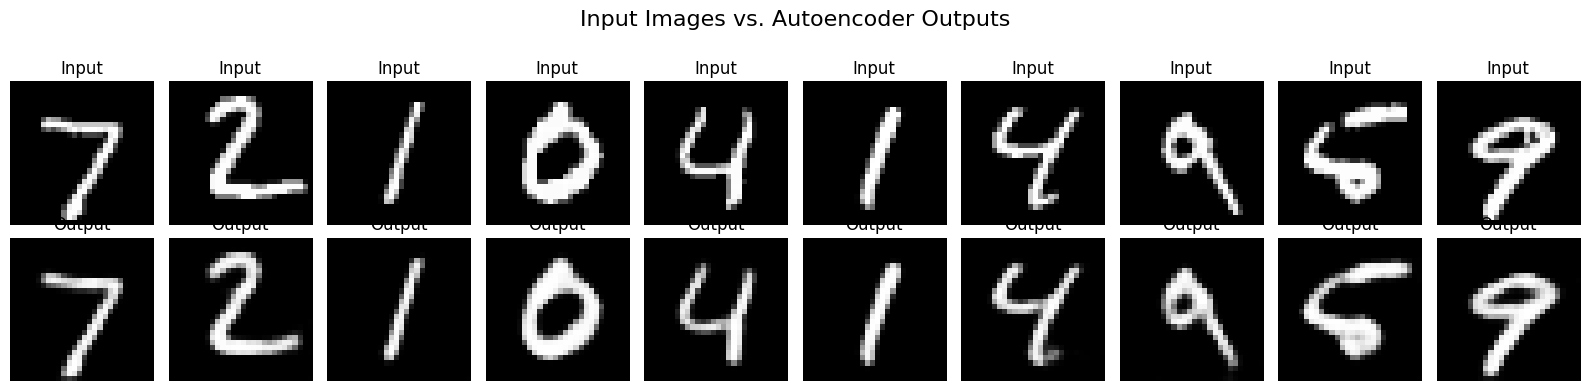

In [44]:
# Step 6: Model Assessment and Output Visualization


# Switching the model to evaluation mode
model_instance.eval()
cumulative_test_error = 0.0

# To improve efficiency and save memory, disabling gradient tracking during assessment.
with torch.no_grad():
    # Looping through the test dataset to calculate the reconstruction loss
    for eval_images, _ in test_loader:
        eval_images = eval_images.to(device_type)
        predicted_eval = model_instance(eval_images)
        eval_loss = loss_metric(predicted_eval, eval_images)
        cumulative_test_error += eval_loss.item()

    mean_test_error = cumulative_test_error / len(test_loader)
    print(f"The Mean Reconstruction Error on Test Set: {mean_test_error:.4f}")

    # Retrieving a single batch for visual comparison.
    test_iterator = iter(test_loader)
    example_inputs, _ = next(test_iterator)
    example_inputs = example_inputs.to(device_type)
    predicted_outputs = model_instance(example_inputs)

    # Converting from GPU to CPU and using NumPy for charting
    example_inputs_np = example_inputs.cpu().numpy()
    predicted_outputs_np = predicted_outputs.cpu().numpy()


def show_tensor_image(img_tensor, caption=None):
    """
    It accepts a PyTorch tensor and displays it with Matplotlib.
     If necessary, use denormalization and reshaping.
    """
    img_array = img_tensor.squeeze()
    if img_array.ndim == 3 and img_array.shape[0] == 3:
        img_array = np.transpose(img_array, (1, 2, 0))

    # Undo the normalization from [-1, 1] back to [0, 1].
    img_array = img_array / 2 + 0.5
    img_array = np.clip(img_array, 0, 1)

    plt.imshow(img_array, cmap='gray' if img_array.ndim == 2 else None)
    if caption:
        plt.title(caption)
    plt.axis('off')

# Displaying a few original and comparable recreated samples.
num_display = 10
plt.figure(figsize=(16, 4))
for idx in range(num_display):
    # Showing the original image
    plt.subplot(2, num_display, idx + 1)
    show_tensor_image(example_inputs_np[idx], caption="Input")

    # Showing the reconstructed image
    plt.subplot(2, num_display, idx + 1 + num_display)
    show_tensor_image(predicted_outputs_np[idx], caption="Output")

plt.suptitle("Input Images vs. Autoencoder Outputs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig("reconstructions.png")
#print("Saved comparison visualization as 'reconstructions.png'")
plt.show()


# This step assesses the autoencoder's performance by analyzing unseen test
# data and provides the average reconstruction loss.  The tool compares original
# and rebuilt images to demonstrate the model's ability to represent and reconstruct MNIST digits accurately.


Encoded feature shape: (1024, 32)
Label array shape: (1024,)
Performing t-SNE for dimensionality reduction...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(



Generating synthetic samples from latent space...


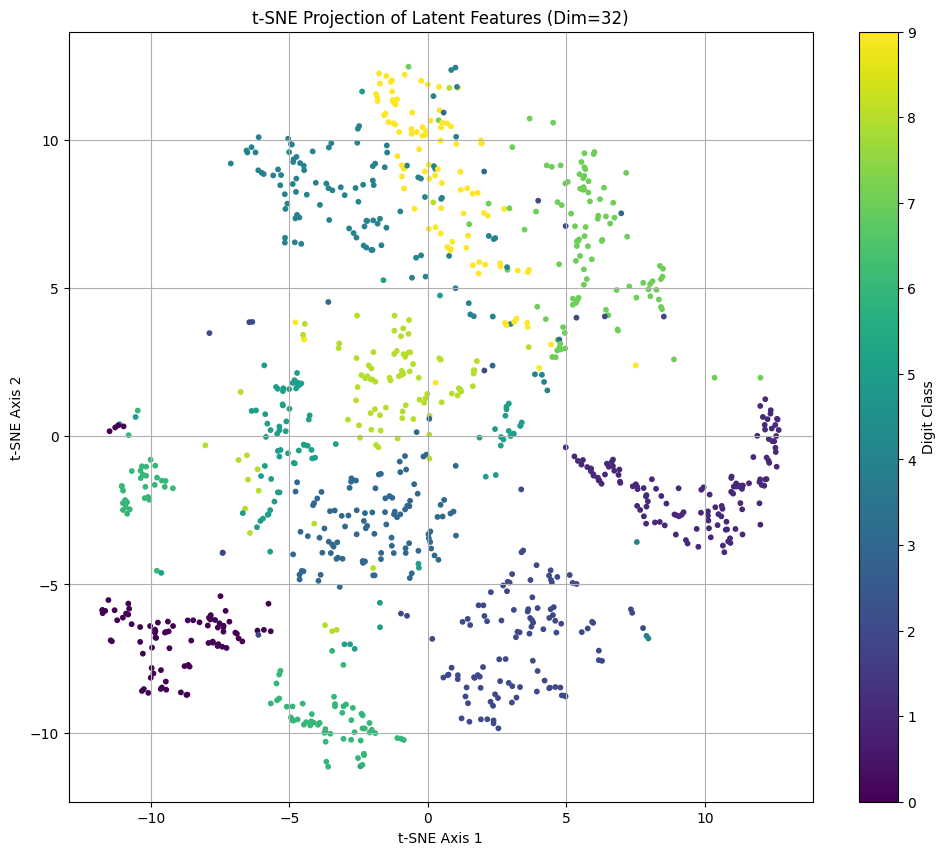

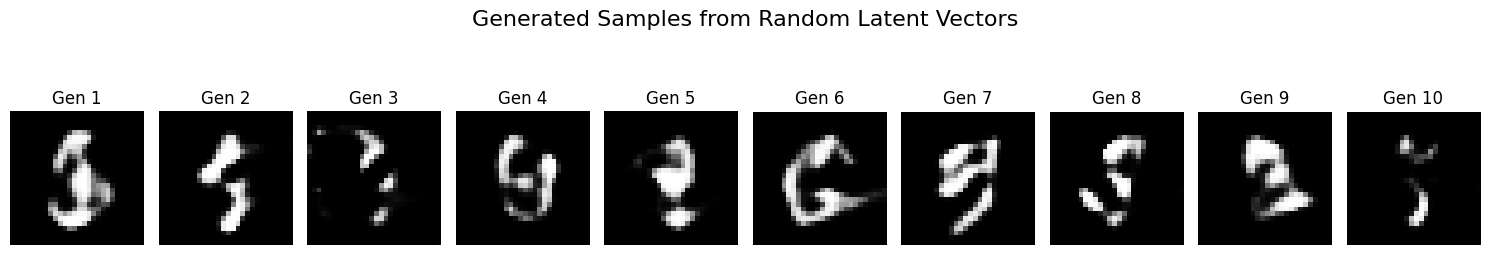

In [45]:
# Step 7: Feature Space Exploration and Visualization
batch_size = 64

# Preparing to gather encoded features and class tags from the test set.
latent_features_collection = []
class_labels_collection = []
model_instance.eval()

# Disabling autograd to improve inference efficiency
with torch.no_grad():
    for batch_idx, (img_set, label_set) in enumerate(test_loader):
        if batch_idx * batch_size > 1000:
            break
        img_set = img_set.to(device_type)
        encoded_features = model_instance.encode_only(img_set)
        latent_features_collection.append(encoded_features.cpu().numpy())
        class_labels_collection.append(label_set.numpy())

#Combining all collected arrays into a single NumPy matrix.
latent_features = np.concatenate(latent_features_collection, axis=0)
class_labels = np.concatenate(class_labels_collection, axis=0)

print(f"Encoded feature shape: {latent_features.shape}")
print(f"Label array shape: {class_labels.shape}")

# Apply t-SNE to reduce latent features to 2D for visualization
try:
    from sklearn.manifold import TSNE
    print("Performing t-SNE for dimensionality reduction...")
    tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_2d_projection = tsne_model.fit_transform(latent_features)

    # Ploting the t-SNE projection
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(tsne_2d_projection[:, 0], tsne_2d_projection[:, 1],
                          c=class_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Digit Class')
    plt.title(f't-SNE Projection of Latent Features (Dim={compressed_vector_size})')
    plt.xlabel('t-SNE Axis 1')
    plt.ylabel('t-SNE Axis 2')
    plt.grid(True)
    #plt.savefig("latent_space_tsne.png")
    #print("Saved t-SNE latent feature plot as latent_space_tsne.png")
except ImportError:
    print("scikit-learn is not installed. Skipping t-SNE projection.")
    print("Install with: pip install scikit-learn")

#Producing synthetic images from random latent vectors if the dimension is controllable.
if compressed_vector_size <= 64:
    print("\nGenerating synthetic samples from latent space...")
    model_instance.eval()
    with torch.no_grad():
        samples_to_generate = 10

        # Calculate the average and standard deviation of encoded characteristics.
        latent_mean = torch.tensor(latent_features.mean(axis=0), dtype=torch.float32).to(device_type)
        latent_std = torch.tensor(latent_features.std(axis=0), dtype=torch.float32).to(device_type)

        # Based on the learnt statistics, sampling new vectors using the normal distribution.
        random_latents = torch.normal(
            mean=latent_mean.repeat(samples_to_generate, 1),
            std=latent_std.repeat(samples_to_generate, 1)
        ).to(device_type)

        # Decode latent points to create synthetic images.
        generated_imgs = model_instance.decode_only(random_latents)
        generated_imgs_np = generated_imgs.cpu().numpy()

    plt.figure(figsize=(15, 3))
    for i in range(samples_to_generate):
        plt.subplot(1, samples_to_generate, i + 1)
        show_tensor_image(generated_imgs_np[i], caption=f"Gen {i+1}")
    plt.suptitle("Generated Samples from Random Latent Vectors", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig("generated_from_latent.png")
    #print("Generated image grid saved as generated_from_latent.png")
else:
    print("Latent dimension too high for random generation preview. Skipping.")



